# Challenge Deep Learning

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

L'objectif de ce challenge est de proposer une méthode de classification, basée sur des réseaux de neurones, permettant de classer des images issues de Google Quickdraw (https://quickdraw.withgoogle.com/data).
Le jeu de données proposé comprend 5 classes balancées, avec 15000 exemples d'apprentissage et 5000 exemples de validation : des paniers, des yeux, des lunettes, des lapins et des mains.

Vous pouvez utiliser tout algorithme qui vous semble pertinent (PMC, CNN,), en faisant varier les données d'entrée (normalisation, augmentation de données,...), les paramètres des réseaux considérés (fonction objectif, optimiseur, dropout, learning rate, taille des batchs...)

Bien sûr, pour valider votre travail, nous ferons tourner le code en local, sur la base originale que nous conservons, pour voir si les résultats que vous proposez sont reproductibles.

Le compte-rendu sera effectué sur un notebook jupyter, dans lequel vous reporterez votre méthodologie en markdown, et vos codes en Python. Vous expliquerez votre démarche, justifierez vos choix, commenterez vos expérimentations et vos résultats.

La notation sera construite de la manière suivante :
- 12 points sur le compte-rendu
- 8 points seront accordés sur un classement par le taux de reconnsaissance des objets de la base de test. Les binômes seront classés par taux de reconnaissance décroissant, les premiers ayant 8 points accordés, les autres binômes ayant une note suivant une décroissance linéaire.

Le notebook sera déposé sur la plateforme moodle du cours.

## Introduction
Notre objetif est de concevoir un modèle de réseaux de neurones convolutionels afin de d'éffectuer la classification des images en 5 catégories<br>
Notre travail s'articulera autour des points suivants : <br>
* Tester une variétée d'architecture, principalement - des architectures de types VGG, Resnet et Inception - pour en choisir la meilleur architecture repondant à notre besoin<br>
* Augmentation de données (data augmentation) pour en avoir plus de données d'entraînement

## Imports
* Import de toutes les couche necessaires pour la conception d'un modèl
* Autres import pour sauvegarder le meilleur modèle lors de l'entraînement, changer le taux d'entraînement lors de l'entraînement

In [30]:
#Import de toutes les couches keras
import tensorflow as tf # Tensoflow
from tensorflow import keras as keras # Keras
from tensorflow.keras.models import Sequential # Pour la concetion d'un modèle séquentiel ou des couches séquentielles
from tensorflow.keras import Model # Pour concevoir un modèle de type Keras
from tensorflow.keras.layers import Conv2D # Couche convolutionnelle
from tensorflow.keras.layers import MaxPooling2D # Couche de pooling
from tensorflow.keras.layers import Flatten # Couche permettant de transformer une donnée 2D (image) en un donnée 1D (vecteur)
from tensorflow.keras.layers import Dense # Pour la conception de couches complètement connectées 
from tensorflow.keras.layers import Dropout # Couche de regularization
from tensorflow.keras.layers import Input # Couche d'entrée
from tensorflow.keras.layers import BatchNormalization # Couche de normalization ou standardisation
from tensorflow.keras.layers import ReLU # Couche d'activation
from tensorflow.keras.layers import GlobalAveragePooling2D # Autre couhe de pooling
from tensorflow.keras.utils import plot_model
from keras.models import load_model

#Pretraitement des données
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Pour charger et prétraiter les données 

# Autres import 
from tensorflow.keras.callbacks import ModelCheckpoint # Pour sauvegarder le modèle ayant la meilleur précision sur le jeu de données
                                                        # de validation lors de l'entraînement
from tensorflow.keras.callbacks import LearningRateScheduler # Pour changer le learning rate de manière dynamique lors de l'entraînement

import pandas as pd # Pour gérer le dataFrame
import numpy as np # Pour la manipoulation de tableaux numpy

# from PIL import Image
# import glob
import matplotlib.pyplot as plt # Pour les affichages graphique
%matplotlib inline

#Data Augmentation
import cv2 # Pour les transorformation géométriques des données
import os 

## Data Augmentation
### Definition
L'augmentation de données, data augmentation en anglais, est une techniques permettant d'appliquer des transformations sur les données originales<br> afin d'avoir plus de données pour l'entraînement de notre modèle. 
Ces transformations sont diverses. 
### Différents types de data Augmentation
#### Les transformations simples
Les plus simples d'entres elles permettent simplement d'effectuer des transformations géométriques, le filtrage ou encores le changement d'espace de couleur. Les plus connus d'entre ces techniques sont :
* Les rotions selon divers angles de rotation.
* Les retournement(flip) horizontaux, vericaux, ..
* Le filtrage à travers divers filtres.
* L'ajout de brouille(gaussien, uniforme).
* Les coups aléatoires (Random crop).
* Le changement de couleur.
* Cutout, consistant à masquer une partir de l'image. <a href="https://arxiv.org/pdf/1708.04552.pdf"> Terrance DeVries et al.</a> <br>
#### Données synthétiques
Les transformations basiques ne sont pas souvent assez robuste pour apporter une grande varité. Se faisant il y'a une variété de transformations plus sofistiquées utilisées pour générer des données synthétiques. 
Ce sont : <br>
* L'usage des GANs pour la génération de données <a href="https://arxiv.org/pdf/2306.02019.pdf" > Angona Biswas et al. </a><br>
Cette approche necéssite un entraînement à l'avance avec les données d'entraînement afin d'en générer de nouvelles images sur la base de la distribution de des données d'entraînement apprise.
* L'usage de transfert de style (Neural Style Transfer) <a href="https://arxiv.org/pdf/1909.01056.pdf"> Xu Zheng et al.</a> Cette permet de créer des nouvelles données en changeant la texture , la couleur et la luminosité via une transformation non linéare.

L'objectif de la data augmentation est de générer plus de données pour l'entraînement afin d'éviter les sur-entraînements surtout quand l'on dispose d'une petite basse de données d'entraînement, car la capacité des modèles de réseaux de neurones profonds résident de la capacité de généralisation après être entraîné avec une grosse base de données <a href="https://arxiv.org/pdf/1909.01056.pdf"> Xu Zheng et al</a>, <a href="https://arxiv.org/pdf/2306.02019.pdf" > Angona Biswas et al</a>. Le problème est que la collection d'une grosse base de données d'entraînement peut être parfois très coûteuse. Parfois il est dificile voire impossible d'avoir accès à une grosse base données d'entraînement même si l'on en a les ressources nécessaires. Ces limites font la data augmentation une solution intéressante dans diverses domaines. 

#### Limites de la data augmentation
* Les transformations simples peuvent ne pas apporter un grand changement quant à la capacité du modèle à généraliser.
* La génération de données de qualité avec les GANs est un autre défit.
* Les biais existant dans les données originelles sont présent dans les données générées via les GANs.

#### Notre cas
Dans notre travail nous avons utilisé que les transformations simples comme la rotation, les retournement en raison des dificultés suivantes:<br>
* Les données sont en niveau de grilles donc pas possible changer l'espace de couleur ni d'appliquer des modèles de Neural Style Transfer pour générer de nouvelles données.
* La tailles des données 28x28 est un frein au random crop (Nos données ont une une taille un peu petite)


In [3]:

def data_augmentation(source_folder,destination_folder,dataframe):
    """ Args:
            source_folder : Repertoir source où sont les vraies images d'entraînement
            
            destination_folder : Repertoire de destination où les données augmentées seront sauvegarder y compris une copie des données réelles.
            Une fois les données augmentées, seules les données de cette repertoire seront utilisées comme jeux de données d'entraînement de nos
            différent modèle
            
            dataframe : DataFrame contenant les nom des images destinées à l'entraînement. Rappelons que le jeux de données d'entraînement de test ne
            sont dans le même repertoire. 
    """
    dir=os.listdir(source_folder) 
    
    for i in range(5): # Boucle pour créer les 5 sous répertoire representant les différentes classes du jeu d'entraînemet
        subpath=os.path.join(source_folder,dir[i])
        dirr=os.listdir(subpath)
        new_sub_folder=os.path.join(destination_folder,dir[i])
        os.makedirs(new_sub_folder) # Création d'un sous répertoire
        for file in dirr: #Parcours du répertoire où sont staockées les images d'entrainément. C'est l'un des 5 sous répertoires représenatant les classes
            for filename in dataframe: # Parcours du dataFrame contenant les noms des images d'entraînement
                if filename==file: # Comparaison entre nom du fichier du repertoire courant et le nomù du fichier de la dataframe 
                    file_path = os.path.join(subpath, filename) # Obtension du chemin complet du fichier du répertoire courant
                    image=cv2.imread(file_path,-1) #Ouverture du fichier via le dhemin obtenu précédemment. -1 indique ici que nous chargeons l'image
                                                    # Sous son format original. Par défaut OpenCV ouvrira l'image avec 3 canaux. D'où l'intérêt de changer 
                                                    # Le flag à -1
                    shutil.copy(file_path, new_sub_folder) # Copy de l'image dans notre nouvelle sous répertoire. On se contente de copier plutôt que 
                                                           # de déplacer dans l'image dans le nouveau répertoire. Cela nous permet de garder les images
                                                           

                    flip_types = [0, 1, -1] # Flags pour retourner nos images en 3 différents sens (retournement par erapport à l'axe x, y, ..)

                    # Boucle pour le retourner de chaque image en trois différents formes
                    for flip_type in flip_types:
                        
                        flipped_image = cv2.flip(image, flip_type)
                        flip_label = "_hflip" if flip_type == 0 else "_vflip" if flip_type == 1 else "_vhflip"
                        
                        f = f"{file_path[:-4]}{flip_label}.png"
                        cv2.imwrite(f,flipped_image)
                        shutil.move(f, new_sub_folder)

    
                    w,h=image.shape
                    centerX, centerY=(w//2,h//2)

                    rotations = [30, 60, -30, -60]# Les différents angles de rotaion

                    #Boucle pour effectuer diverses rotations de l'image de base
                    for angle in rotations:
                        M = cv2.getRotationMatrix2D((centerX, centerY), angle, 1.0)
                        rotated = cv2.warpAffine(image, M, (w, h))
                        f = f"{file_path[:-4]}_rotated{angle}.png"
                        cv2.imwrite(f,rotated)
                        shutil.move(f, new_sub_folder)
                    break
                    
                    

def validation_data_creation(source_folder,destination_folder,dataframe):
    """ Args:
            source_folder : Repertoir source où sont les vraies images de validation
            
            destination_folder : Repertoire de destination où les données de validation  seront sauvegarder.
            
            dataframe : DataFrame contenant les nom des images destinées à l'entraînement. Rappelons que le jeux de données d'entraînement de test ne
            sont dans le même repertoire. 
    """
    dir=os.listdir(source_folder) 
    
    for i in range(5): # Boucle pour créer les 5 sous répertoire representant les différentes classes du jeu d'entraînemet
        subpath=os.path.join(source_folder,dir[i])
        dirr=os.listdir(subpath)
        new_sub_folder=os.path.join(destination_folder,dir[i])
        os.makedirs(new_sub_folder) # Création d'un sous répertoire
        for file in dirr: #Parcours du répertoire où sont staockées les images de validation. C'est l'un des 5 sous répertoires représenatant les classes
            for filename in dataframe: # Parcours du dataFrame contenant les noms des images de validation
                if filename==file: # Comparaison entre nom du fichier du repertoire courant et le nomù du fichier de la dataframe 
                    file_path = os.path.join(subpath, filename) # Obtension du chemin complet du fichier du répertoire courant
                
                    shutil.copy(file_path, new_sub_folder) # Copy de l'image dans notre nouvelle sous répertoire. On se contente de copier plutôt que 
                                                           # de déplacer dans l'image dans le nouveau répertoire. Cela nous permet de garder les images
                                                           

# # Génération des données augmentées

# source_folder = '/home/dah/deep_learning_isima/challenge/images'
# destination_folder = '/home/dah/deep_learning_isima/challenge/train'

# train_csv_path = "train.csv"
# train=pd.read_csv(train_csv_path)
# dataframe=train['image_name']
# data_augmentation(source_folder,destination_folder,dataframe)



# # Création du répertoire contenant les données de validation

# source_folder = '/home/dah/deep_learning_isima/challenge/images'
# destination_folder = '/home/dah/deep_learning_isima/challenge/val'

# train_csv_path = "valid.csv"
# train=pd.read_csv(train_csv_path)
# dataframe=train['image_name']
# data_augmentation(source_folder,destination_folder,dataframe)


### Visualization des effets de la data augmentation

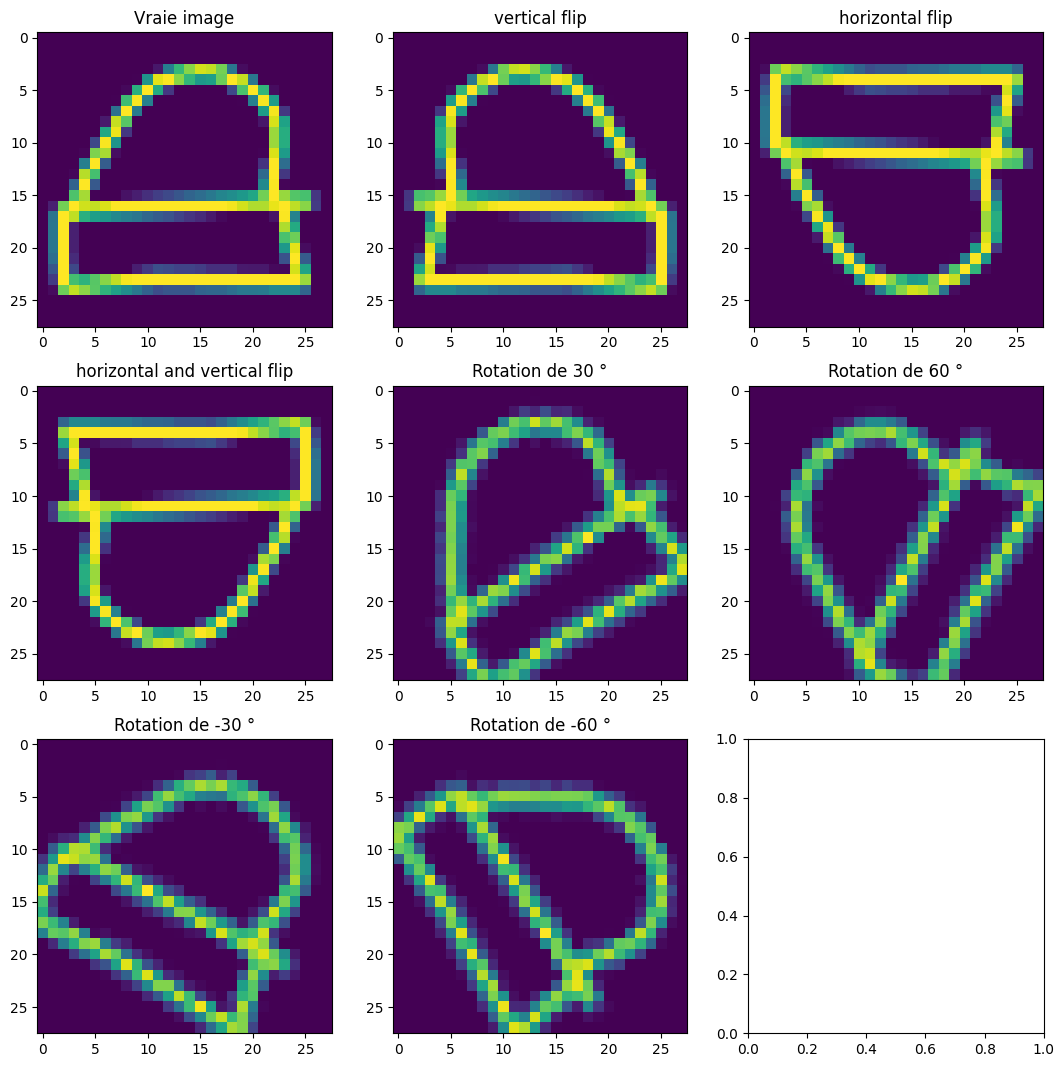

In [23]:
image=cv2.imread("/home/dah/deep_learning_isima/challenge/images/basket/basket_000004.png",-1)

fig, ax=plt.subplots(3,3,figsize=(13,13))
hflip=cv2.flip(image,0)
vflip=cv2.flip(image,1)
vhflip=cv2.flip(image,-1)

w,h=image.shape
centerX, centerY=(w//2,h//2)
M1=cv2.getRotationMatrix2D((centerX,centerY),30,1.0)
rotated1=cv2.warpAffine(image,M1,(w,h))

M2=cv2.getRotationMatrix2D((centerX,centerY),60,1.0)
rotated2=cv2.warpAffine(image,M2,(w,h))

M3=cv2.getRotationMatrix2D((centerX,centerY),-30,1.0)
rotated3=cv2.warpAffine(image,M3,(w,h))

M4=cv2.getRotationMatrix2D((centerX,centerY),-60,1.0)
rotated4=cv2.warpAffine(image,M4,(w,h))


ax[0,0].imshow(image)
ax[0,0].set_title(label='Vraie image')
ax[0,1].imshow(vflip)
ax[0,1].set_title(label='vertical flip')
ax[0,2].imshow(hflip)
ax[0,2].set_title(label='horizontal flip')
ax[1,0].imshow(vhflip)
ax[1,0].set_title(label='horizontal and vertical flip')
ax[1,1].imshow(rotated1)
ax[1,1].set_title(label='Rotation de 30 °')
ax[1,2].imshow(rotated2)
ax[1,2].set_title(label='Rotation de 60 °')
ax[2,0].imshow(rotated3)
ax[2,0].set_title(label='Rotation de -30 °')
ax[2,1].imshow(rotated4)
ax[2,1].set_title(label='Rotation de -60 °')



plt.show()

## Chargement des données
* Nous avons dans une prémier temps sauvegardé nos données dans le répertoire **train** et **val** suivant que la donnée est une donnée d'entraînement ou de validation.
* Nous avons ensuite utilisé un objet de la classe **ImageDataGenerator**<a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator"> ImageDataGenerator </a> pour charger nos différents jeux de donnéees. Les données en entrée de notre modèle sont normalisée via le paramètre **rescale** dans l'objet ImageDataGenerator.
* Une chose très importante est le **batch size** d'entraînement. Si les modèles entraînés possèdent une couche de **Batch Normalization**, il faut un batch size élevé de sorte à avoir une quantité de données assez representative de la distribution du jeu de données d'entraînement afin que les **moyennes** et **écart-types** calculés dans ces couches soient aussi représentatives.Pour les mini-batch de petite taille ou les mini-batch qui ne contiennent pas une distribution représentative des exemples de l'ensemble de données d'apprentissage, les différences dans les entrées normalisées entre l'apprentissage et l'inférence (utilisation du modèle après l'apprentissage) peuvent entraîner des différences notables en termes de performances.<a href="https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/"> Batch size </a>
Aussi les petit-lot de batch ne garantissent par une covergence **rapide** et **stable** des algorithmes d'optimisation utilisant la méthode de descente de gradient stochastiques car les poids sont mis à jour en s'appuyant sur des données qui ne sont pas répresentatives. Ce problème de taille de batch à d'ailleurs l'objet de plusieurs études dont en voici quelques unes <a href ="https://arxiv.org/pdf/1910.08222.pdf" >Scott Sievert et al</a>, <a href ="https://arxiv.org/pdf/2206.01029.pdf" >Kiwon Lee et al</a> <br>
Bien que le gros lots de batch presentent de nombreuses avantages, ils exigent plus deressources mémoires. 

In [6]:

batch_size=256

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    directory="train/",
    target_size=(28, 28),
    color_mode='grayscale',
    # classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)


valid_data = datagen.flow_from_directory(
    directory="val/",
    target_size=(28, 28),
    color_mode='grayscale',
    # classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)


Found 600000 images belonging to 5 classes.
Found 25000 images belonging to 5 classes.


En agissant comme le montre le code ci-dessus nous avons determinee que la dimension des images est de 28x28. Nous avons jugee cette taille suffisante et nous avons decidee de ne pas redimensionner les images

## Mise en place des différents modèles
### Objectifs
La conception de ces différents modèles repond à différents objectifs:
* Découvrir comment mettre en place un modèle perfomant de réseaux de neurones profonds en partant de zéro.
* Découvrir les raisons d'utiliser certaines couches par rapport à d'autres.
* Découvrir différentes architectures de réseaux convolutionnels.
### Théorie des couches constituant l'architecture d'un modèle CNN (Convolutional Neural network)
Dans les lignes qui suivent nous allons présenter les différentes couches couramment présentes dans l'architecture de CNNs.<br>
Etant donné que ces couches seront utilisées dans nos différents modèles nous allons  expliquer brièvement pourquoi nous les avons utilisées
#### Couche de convoltion
* Les couches de convolution sont préférables aux couches complètement connectées car elles ont l'avantage d'extraire des caractéristiques localement. Ce qui n'est pas le cas pour les couches complètement connectées qui traitent un pixel indépendamment de ses pixels voisins. Avec les couches complètement connectées on perd la notion de spacialité.
* Les couches de convolution sont le plus souvent utilisées avec des kernel de petit taille (3x3) car il est pertinent de traiter un pixel est tenant compte de ses plus proches voisins que des voisins qui sont très éloignés possédant ainsi des caratéristiques pouvant être très différents du pixel traité.
* Le **ConvBlock** ci-dessus sera utilisé avec des **kernel size** 3x3 ou 1x1
#### Couche de Batch Normalization
Cette couche à pour objectif de normalizer données en utilisant la **moyenne** et **l'écart-type** du **lot de batch** traité. La normalisation permet d'accélérer l'entraînement de notre modèle. En fait elle assure une convergence **stable** et **rapide** de la fonction de perte lors de la descente du gradient. Lorsque les activations à l'entrée ou à la sortie d'une couche ne sont pas normalisées, elles peuvent prendre des valeurs très grandes en valeur absolue. Cela entraîne la disparition du gradient pour des fonctions d'activation de type sigmoid car la dérivé de celle-ci tend vers zéros( $sigmoid(x)=g(x)=\frac{1}{1+ exp(-x)} $ et $g'(x)=g(x)(1-g(x))$)  ) comme expliqué par <a href="https://arxiv.org/pdf/1502.03167.pdf" >  Sergey Ioffe et al</a>. Le problème de disparition de gradient(Vanishing gradient problem) a pour conséquence de rendre l'apprentissage très lent car les couches d'entrées reçoivent des gradients quasiment nuls lors de la phase de rétropropagation(back propagation) entraînant ainsi la non la non mise à jour des poids de ces dernieres. Aussi <a href="https://arxiv.org/pdf/1502.03167.pdf" >  Sergey Ioffe et al</a> expique que la **batch normalization** nous permet d'entraîner plus aisément un modèle de deep learning sans trop se soucier de la valeur du taux d'apprentissage qui est un hyper paramètre très important devant être choisi avec délicatesse. Il a été ainsi démontré par les auteurs ayant mise en oeuvre cette approche qu'il est **14** plus rapide d'entraîner un modèle de réseaux de neurones ayant de couches de batch normalization que des réseaux qui n'en possèdent pas. Referez vous à<a href="https://arxiv.org/pdf/2209.14778.pdf"> Randall Balestriero </a> pour plus de détails sur le fonctionnement de **batch normalization** et ses avantages.

#### Intiatialisation des paramètres du modèle
* L'initialisation éfficace des paramètres d'un modèle de deep learning est crucial pour avoir une bonne précision.
* L'initialisation non appropriée des paramètres d'un modèle peut lourdement affecté sa performance car en effet chaque couche ou chaque neurones (chaque filtre dans le cas des réseaux convolutifs) aura tendance à après les mêmes caractéristiques que les autres couches ou neurones.<br>

Les différentes approches pour initialiser les paramètres sont :
##### Initialisation des paramètres avec une valeur constant :
L'apporche la plus courantes est d'initialiser tous poids à zéros. Avec cette méthode, les neurones sont succeptible d'apprentres les mêmes caractéristiques. Aussi des valeurs très grandes ou très petites pourront être la cause de l'explosion ou de la disparition du gradient
##### Initialisation aléatoire suivant une distribution de probabilité. 
Les distribuitions les plus couramment utilisées sont la distribution normale et la distribution. Cependant l'initialition aléatoire n'empêche pas de rencontrer le problème de disparition ou d'explosion du gradient.
##### Initialisation de Xavier Glorot
Cette appproche est l'initialisation par **défaut** avec **Keras**. <br>
L'initialisation de faire aussi de manière **aléatoire** suivant une distribution normale ou uniforme avec des **paramètres bien déterminés** permettant d'éviter le problème de disparition ou d'explosion du gradient. Cette iniatilisation suppose plusieurs hypothèses :
* La fonction d'activation doit être impair (**sigmoid** ou **tanh**)
* La variance des activations de la couche $z^i$ est égale à la variation de la couche $z^{i+1}$, c'est-à-dire $ \mathrm{Var}(z^i)=\mathrm{Var}(z^{i+1})$, lors de la phase de propagation
* La variance du gradient de la couche $z^i$ est égale à la variance du gradient de la couche $z^{i+1}$, c'est-à-dire $\mathrm{Var}($$\frac{\partial L}{\partial z^i}$$)=\mathrm{Var}($$\frac{\partial L}{\partial z^{i+1}}$$)$, lors de la phase de rétropropagation.<br>
Ces deux précedentes hypothèse permet d'assurer la non disparition ou la non explosion du gradient. <br>
Vous pouvez vous referez <a href ="https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf" > Xavier Glorot et al </a>(2010)à pour plus de détails quant à cette méthode d'initiamlisation. 

##### Initialisation Kaiming He
Elle adapte le même processus d'initialisation que l'initialisation de **Xavier Glorot** à la seule différence qu'elle parvient à l'étendre et la rendre valide avec des fonctions d'activation non impair, notamment la fonction **ReLU**(Rectified Linear Unit, $ReLU(x)=max(0,x)$)<a href="https://arxiv.org/pdf/1502.01852.pdf"> Kaiming He et al. </a>(2015)

#### Foncrion d'activation ReLU
**ReLU**(Rectified Linear Unit, $ReLU(x)=max(0,x)$ est une fonction d'activation très couramment utilisé dans les modèles de réseaux de neurones profonds du fait de sa capacité à introduire la linéarité lors de l'apprentissage. Elle a pour avantage d'être une solution fiable quant aux problèmes d'explosion ou de disparition du gradient.

#### Regualarisarion Dropout
<a href="https://arxiv.org/pdf/1207.0580.pdf"> G. E. Hinton et al </a> (2012) ont expliqué dans leur papier que les réseaux de neurones complètement connectés (feedforward neural network) sont sujets aux sur-entraînements(overfitting) lorsque ces derniers sont entraînés sur de petites bases de données. Pour augmenter la capacité de généralisation de ces réseaux ils ont mis en oeuvre la technique de **Random Dropout** qui consiste à omettre certains neurones lors de la phase de propagation. Cette technique s'avère promeuteuse sur diverses tâches notamment dans des tâches de classifications. Le **dropout** est l'une des meilleures techniques de régularisation permettant de réduire l'overfittinhg.<br>
L**overfitting** a lieu lorsque nous expérimentons une **très bonne précision**(accuracy) **sur le jeu de données d'entraînement** et une **faible précision sur le jeu de données de test**.On peut par exemple atteindre **99%** de précison lors de l'enttraînement et **90%** lors de la validation <br>


#### Sunthèse
Plusieurs techniques ont été mises en place afin de lutter contre l'explosion et la disparition du gradient notamment avec la techniques d'initialisation de **Xavier Glorot** et **Kaiming He**, l'introduction de la fonction d'activation **ReLU**.
* D'un côté, éviter l'exposion de gradient permet d'assurer une **convergence stable** de la fonction  de perte.
* D'un autre côté, éviter le problème de disparution du gradient permet d'assurer une **Convergence rapide** de la fonction de perte
* Cependant  <a href="https://arxiv.org/pdf/1502.03167.pdf" >  Sergey Ioffe et al</a> a démontré que la technique du **batch normalization** permettait d'entraîner efficacemment un modèle de réseau de neurones profonds sans trop s'attarder sur les techniques d'initialisation des poids car la technique **batch normalization** est très souvent robuste pour éviter la disparution et l'explosion du gradient en assurant une convergence rapide et stable du modèle.

#### Notre cas 
Au vu de tout ce qui précède voici comment nous avons conçu nos différents modèles:
* Couche de convolution constituée de **kernel size** vallant 3x3 ou 1x1
* Couche de batch Normalization
* Fonction d'activation : **ReLU**
* Initialisation des poids : Initiatialiation **Xavier Glorot**

### ConvBlock
Cette couhe est utilisé pour soucis de **factorisation**
de code dans la mise en place des différents modèles. <br>
Elle est constitué d'une couhe de convolution, de batch normalization et d'avtivation ReLU que nous choissons d'ajouter ou pas en fonction du besoin

In [24]:
class ConvBlock(keras.layers.Layer):

    def __init__(self,num_filters,kernel_size,strides,padding,activation=None):

        super(ConvBlock,self).__init__()
        self.layer=Sequential([
            Conv2D(filters=num_filters,kernel_size=kernel_size,strides=strides,padding=padding),
            BatchNormalization()
        ])
        
        self.activation=activation
        
        if self.activation: #On decide d'ajouter une activation ou pas. Cela serait utile lors de la mise en oeuvre de Residual connection.
            self.relu=ReLU()

    def call(self,inputs):
        x=self.layer(inputs)
        
        return self.relu(x) if self.activation else x


## Visualisation de ConvBlolck

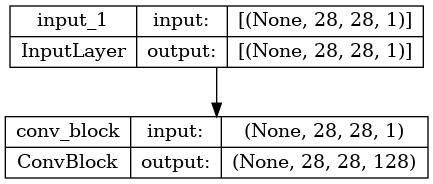

In [8]:
input=Input(shape=(28,28,1))

convb=ConvBlock(num_filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation="relu")(input)
model=keras.Model(inputs=input, outputs=convb)
plot_model(model, to_file='convb_plot.png', show_shapes=True, show_layer_names=True)

## Couche MLPs (Multi layers Perceptrons)
Cette couche est constitué de couche de neurones complètement connecté afin d'effectuer la tâche de classification une fois que les caractéristiques ont été extraient par les couches convolutionelles.<br>
Cette couche a été créer par soucis de **factorisation** de code.

In [9]:
class MLPs(tf.keras.layers.Layer):

    def __init__(self,units=1042,dropout=0.4):

        super(MLPs,self).__init__()
        self.mlp=Sequential([
            Dense(units=units,activation='relu',name='fc1'),
            Dropout(dropout,name='dropout1'),
            Dense(units=5,activation='softmax')
        ])

    def call(self,inputs):
        return self.mlp(inputs)

## Visualisation de MLPS

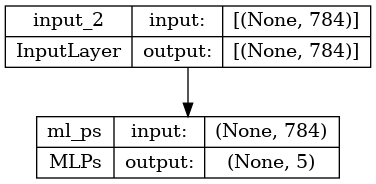

In [10]:
input=Input(shape=(28*28,))

mlps=MLPs(units=1042,dropout=0.4)(input)
model=keras.Model(inputs=input, outputs=mlps)
plot_model(model, to_file='mlps_plot.png', show_shapes=True, show_layer_names=True)

### Conception de Mini VGG
Nous avons adopté une architecture de type VGG qui est en effet une empilement de couche de **convolution** suivit de couche de d'**activation** et de **Maxpooling**
* Les couches de **convolution** sont des **ConvBlock**.
* L'architecture du papier original ne contient pas de couche de **Batch Normalization** mais nous les avons ajoutées afin d'éviter tous les problèmes que nous avons énuméré précédemment.
* La couche de **Maxpooling** permet d'extraire les caractéristiques les plus importantes sans s'attarder au détails qui rendraient l'apprentissage **lent** du fait de la **dimensionalité** des **cartes caractéristiques**(feature map)<br>

Pour plus de détails quand à l'architecture de **VGG** vous pouvez vous referez à <a href ="https://arxiv.org/pdf/1409.1556.pdf"> Karen Simonyan  et al</a> (2015).

#### Définition et implémentation du modèle

In [11]:
class MiniVGG(keras.Model):

    def __init__(self,units=1024,dropout=0.4):

        super(MiniVGG,self).__init__()

        self.layer1=Sequential([
            ConvBlock(num_filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation="relu"),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])

        self.layer2=Sequential([
            ConvBlock(num_filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation="relu"),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])

        self.layer3=Sequential([
            ConvBlock(num_filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation="relu"),
            ConvBlock(num_filters=128,kernel_size=(3,3),strides=(1,1),padding='same',activation="relu"),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])
        self.layer4=Sequential([
            ConvBlock(num_filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation="relu"),
            ConvBlock(num_filters=256,kernel_size=(3,3),strides=(1,1),padding='same',activation="relu"),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])
        
        self.gap=GlobalAveragePooling2D(name="GlobalAveragePooling2D")
        self.flatten=Flatten()
        
        self.mlp=MLPs(units=units,dropout=dropout)
        
    def call(self,inputs):
        layer1=self.layer1(inputs)
        layer2=self.layer2(layer1)
        layer3=self.layer3(layer2)
        layer4=self.layer4(layer3)
        flatten=self.flatten(self.gap(layer4))

        return self.mlp(flatten)

### Visualisation de Mini VGG

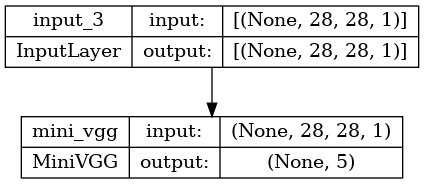

In [12]:
input=Input(shape=(28,28,1))

miniVGG=MiniVGG(dropout=0.6)(input)
model=keras.Model(inputs=input, outputs=miniVGG)
plot_model(model, to_file='miniVGG_plot.png', show_shapes=True, show_layer_names=True)

### Entraînement de Mini VGG

#### Instanciation du modèle
Lors de l'entraînement, modèle ayant le aynt le **meilleiur accuracy** sur le jeu de **données de validation** sera sauvegarder <br>
Le sauvegarde se faire via le **callback** **ModelCheckpoint** de Keras.

##### scheduler
Pour permettre de changer progressivement le **learning rate** durant l'entraînement

In [14]:
def scheduler(epoch, lr):
    if epoch % 10 !=0:
        return lr
    else:
        return lr * np.exp(-0.1)

In [15]:
data=Input(shape=(28,28,1))
miniVGG=MiniVGG(dropout=0.6)
conv=miniVGG(data)

checkpoint_filepath = 'best_mini_vgg.h5'
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

miniVGG=keras.Model(inputs=data,outputs=conv)
miniVGG.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 mini_vgg_2 (MiniVGG)        (None, 5)                 1416133   
                                                                 
Total params: 1416133 (5.40 MB)
Trainable params: 1414341 (5.40 MB)
Non-trainable params: 1792 (7.00 KB)
_________________________________________________________________


#### Entraînement proprement dit
* Optimiseur : **Adam**
Cette optimiseur est celui qui garantit la convergence rapide du modèle comparé à l'optimizeur **RMSprop**<br>
Nous avons aussi mise place un scheduler afin de diminuer progressivement le **learning rate** durant l'entraînement mais cela ne semble pas apporter d'amélioration particulière quant comparé au learning rate par défaut.
* Fonctiond de perte : **Entropie croisée**
* Métrique d'évaluation : **Acuracy**
* Epochs : **100** pour s'assurer de la convergence du modèle

In [105]:
# opt=keras.optimizers.RMSprop(learning_rate=0.001,momentum=0.9)
miniVGG.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = miniVGG.fit(train_data, epochs=100, validation_data=valid_data,callbacks=[model_checkpoint])

Epoch 1/100
2344/2344 [==============================] - ETA: 0s - loss: 0.2252 - accuracy: 0.9232
Epoch 1: val_accuracy improved from -inf to 0.94324, saving model to best_mini_vgg.h5
2344/2344 [==============================] - 249s 106ms/step - loss: 0.2252 - accuracy: 0.9232 - val_loss: 0.1673 - val_accuracy: 0.9432
Epoch 2/100
2344/2344 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9550
Epoch 2: val_accuracy improved from 0.94324 to 0.95196, saving model to best_mini_vgg.h5
2344/2344 [==============================] - 246s 105ms/step - loss: 0.1330 - accuracy: 0.9550 - val_loss: 0.1459 - val_accuracy: 0.9520
Epoch 3/100
2344/2344 [==============================] - ETA: 0s - loss: 0.1120 - accuracy: 0.9616
Epoch 3: val_accuracy improved from 0.95196 to 0.95920, saving model to best_mini_vgg.h5
2344/2344 [==============================] - 246s 105ms/step - loss: 0.1120 - accuracy: 0.9616 - val_loss: 0.1228 - val_accuracy: 0.9592
Epoch 4/100
2344/2344 [=====

#### resultats
* **96.64%** d'accuracy sur sur le jeux de données de validation avec un entraînement sur le jeu de données d'entrainement obtenu par **data augmentation**
* Accuracy autour de **94%** sur sur le jeux de données de validation avec un entraînement sur le jeu de données d'entrainement obtenu par **sans data augmentation**
* On constate néanmoins un **overfitting** malgré la régularisation **dropout**
* Nous avons aussi constaté que le learning rate par défaut fonctionnaire plutôt bien de même que l'initialisation par défaut (**Xavier Glorot**). Cela est problément dû au différents couches de **Batch Normalization** que nous avons introduit

## ResidualBlock
Malgré les diverses solutions précédemment présentées pour resoudre le problème de **vanishing** ou **exploding** gradient presiste si le modèle devient de plus en profond comme l'explique <a href="https://arxiv.org/pdf/1512.03385.pdf"> Kaiming He et al </a>(2015). Cependant, la profondeur d'un modèle joue une rôle crucial quant à sa capacité d'extraire des caractéristiques (feature map) <a href="https://arxiv.org/pdf/1512.03385.pdf"> Kaiming He et al </a>. Plus le modèle devient profond plus sa performance se degrade (<a href="https://arxiv.org/pdf/1512.03385.pdf"> Kaiming He et al </a>) alors qu'il a été empiriquement démontrer par <a href="https://arxiv.org/pdf/1409.4842.pdf"> Christian Szegedy et al </a>, <a href="https://arxiv.org/pdf/1409.1556.pdf"> Karen Simonyan et al </a> que la profondeur permet d'extraire plus caractéristiques et donc plus performance.
* Comment permet à un modèle de réseaux profond d'augmenter sa profondeur sans **dégradation** de sa perfomance ?
* Existe-il d'autres solutions de contourner le problème de **vanishing** ou **exploding** engendrer pas la profondeur du réseau <br>

Une réponse à ses intérrogations a été élucidé par <a href="https://arxiv.org/pdf/1512.03385.pdf"> Kaiming He et al </a>(2015)<br>
Leur solution consistait à utiliser les sauts de connections(**skipping connection**) afin d'apporter plus d'informations aux couches plus profondes. <br>
La figure ci-dessous illustre le mécanisme de skipping connection.

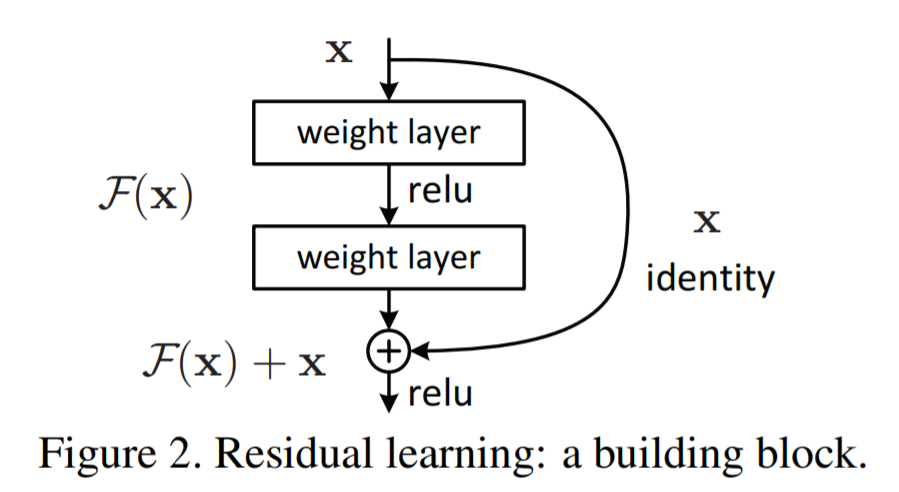

In [19]:
from IPython import display
display.Image("https://blog.kakaocdn.net/dn/dBesUR/btqVyUjjEyV/gCqE4ukhiXR2J0yw70xpOK/img.png")

In [27]:
class ResidualBlock(keras.layers.Layer):

    def __init__(self,filter1,filter2,kernel_size2,stride1,padding1,downsample_state=False):

        super(ResidualBlock,self).__init__()

        self.layer=Sequential([
            ConvBlock(num_filters=filter1,kernel_size=(3,3),strides=stride1,padding=padding1,activation="relu"),
            ConvBlock(num_filters=filter2,kernel_size=kernel_size2,strides=(1,1),padding="same",activation=None)#La 2ième couche de notre de notre 
                                                                                                                # ResidualBlock ne possède pas d'actiavation
                                                                                                                #L'activationn sera ajouter après avoir addictionner
                                                                                                                # La sortie de cette couche et le skipping connection
        ])
        
        self.downsample_state=downsample_state #Si le downsample_state=True alors le skipping connection est une couche de convolution
                                               # Si downsample_state=False alors le skipping connection est une couche de convolution
        
        if self.downsample_state :
            self.downsample=ConvBlock(num_filters=filter2,kernel_size=kernel_size2,strides=stride1,padding=padding1,activation=None)
        self.relu=ReLU()

    def call(self,inputs):

        identity=inputs

        if self.downsample_state :
            identity=self.downsample(inputs)

        out=self.relu(self.layer(inputs) + identity)

        return out


### Conception de Mini Resnet
Notre objectif est construire un modèle qui utilise les skipping connection comme **Resnet** sans être pour autant gros comme resnet. En effet le plus petit modèle resnet present sur keras est **Resnet50**, qui est lui d'être un petit modèle.

#### Définition et implémentation du modèle

In [28]:
class MiniResnet(keras.Model):

    def __init__(self,units=1024,dropout=0.4):

        super(MiniResnet,self).__init__()
        self.layer1=Sequential([
            ConvBlock(num_filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])
        
        self.layer2=Sequential([
            ResidualBlock(filter1=64,filter2=64,kernel_size2=(1,1),stride1=(1,1), padding1='same',downsample_state=False),
            ResidualBlock(filter1=64,filter2=64,kernel_size2=(1,1),stride1=(1,1), padding1='same',downsample_state=False),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])

        self.layer3=Sequential([
            ResidualBlock(filter1=128,filter2=128,kernel_size2=(1,1),stride1=(1,1), padding1='same',downsample_state=True),
            ResidualBlock(filter1=128,filter2=128,kernel_size2=(1,1),stride1=(1,1), padding1='same',downsample_state=True),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])

        self.layer4=Sequential([
            ResidualBlock(filter1=256,filter2=256,kernel_size2=(1,1),stride1=(1,1), padding1='same',downsample_state=True),
            ResidualBlock(filter1=256,filter2=256,kernel_size2=(1,1),stride1=(1,1), padding1='same',downsample_state=True),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])

        self.gap=GlobalAveragePooling2D(name="GlobalAveragePooling2D")
        self.flatten=Flatten()
        
        self.mlp=MLPs(units=units,dropout=dropout)

    
    def call(self,inputs):
        layer=self.layer1(inputs)
        layer=self.layer2(layer)
        layer=self.layer3(layer)
        layer=self.layer4(layer)
        flatten=self.flatten(self.gap(layer))

        return self.mlp(flatten)

## Entraînement de Mini Resnet

#### Instanciation du modèle
La même procedure d'entraînement que celle de **Mini VGG** est appliquée ici

In [106]:
data=Input(shape=(28,28,1))
miniResnet=MiniResnet(dropout=0.6)
conv=miniResnet(data)

checkpoint_filepath = 'best_mini_resnet.h5'
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

miniResnet=keras.Model(inputs=data,outputs=conv)
miniResnet.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 mini_resnet_5 (MiniResnet)  (None, 5)                 1756549   
                                                                 
Total params: 1756549 (6.70 MB)
Trainable params: 1751301 (6.68 MB)
Non-trainable params: 5248 (20.50 KB)
_________________________________________________________________


In [107]:
opt=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.9)
miniResnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = miniResnet.fit(train_data, epochs=100, validation_data=valid_data,callbacks=[model_checkpoint])

Epoch 1/100
2344/2344 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.9218
Epoch 1: val_accuracy improved from -inf to 0.93284, saving model to best_mini_resnet.h5
2344/2344 [==============================] - 400s 169ms/step - loss: 0.2314 - accuracy: 0.9218 - val_loss: 0.1978 - val_accuracy: 0.9328
Epoch 2/100
2344/2344 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9548
Epoch 2: val_accuracy improved from 0.93284 to 0.93964, saving model to best_mini_resnet.h5
2344/2344 [==============================] - 399s 170ms/step - loss: 0.1339 - accuracy: 0.9548 - val_loss: 0.1773 - val_accuracy: 0.9396
Epoch 3/100
2344/2344 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9615
Epoch 3: val_accuracy improved from 0.93964 to 0.95756, saving model to best_mini_resnet.h5
2344/2344 [==============================] - 400s 171ms/step - loss: 0.1137 - accuracy: 0.9615 - val_loss: 0.1337 - val_accuracy: 0.9576
Epoch 4/100
2344/23

#### resultats
* **96.82%** d'accuracy sur sur le jeux de données de validation avec un entraînement sur le jeu de données d'entrainement obtenu par **data augmentation**
* L'accuracy s'est nettement amélioré comparé à **Mini VGG** ayant un accuracy de **96.64**

## InceptionBlock_V1
Plutôt de descendre plus en profondeur pour extraire plus de caractéristiques, une autre approche consite à utiliser extracteurs de features concatener en parallèle mais avec des des kernel différents. L'objectif est de pouvoir extraire différents caractériques dans la même couche. Au lieu d'utiliser des **kernel 3x3** dans une couche et des **kernel 1x1** dans la couche suivante, les auteurs ayant inventé cette technoque uilise les **deux types de kernel** dans la même couche mais en **parallèle** plutôt qu'en **séquantiel** comme on le voir dans la majorité des achitectures. Leur approche permet d'eviter de descendre trop en profondeur (éviter exploding ou vanishing gradient problème) tout en étant capable d'extraire autant de caractéristique pertinentes que les réseaux ayant plus de profondeur. Vous pouvez vous referer à <a href="https://arxiv.org/pdf/1512.00567.pdf"> Christian Szegedy et al. </a> pour plus de détails.<br>
L'image ci-dessous illustre bien le mécanisme mise en jeu.

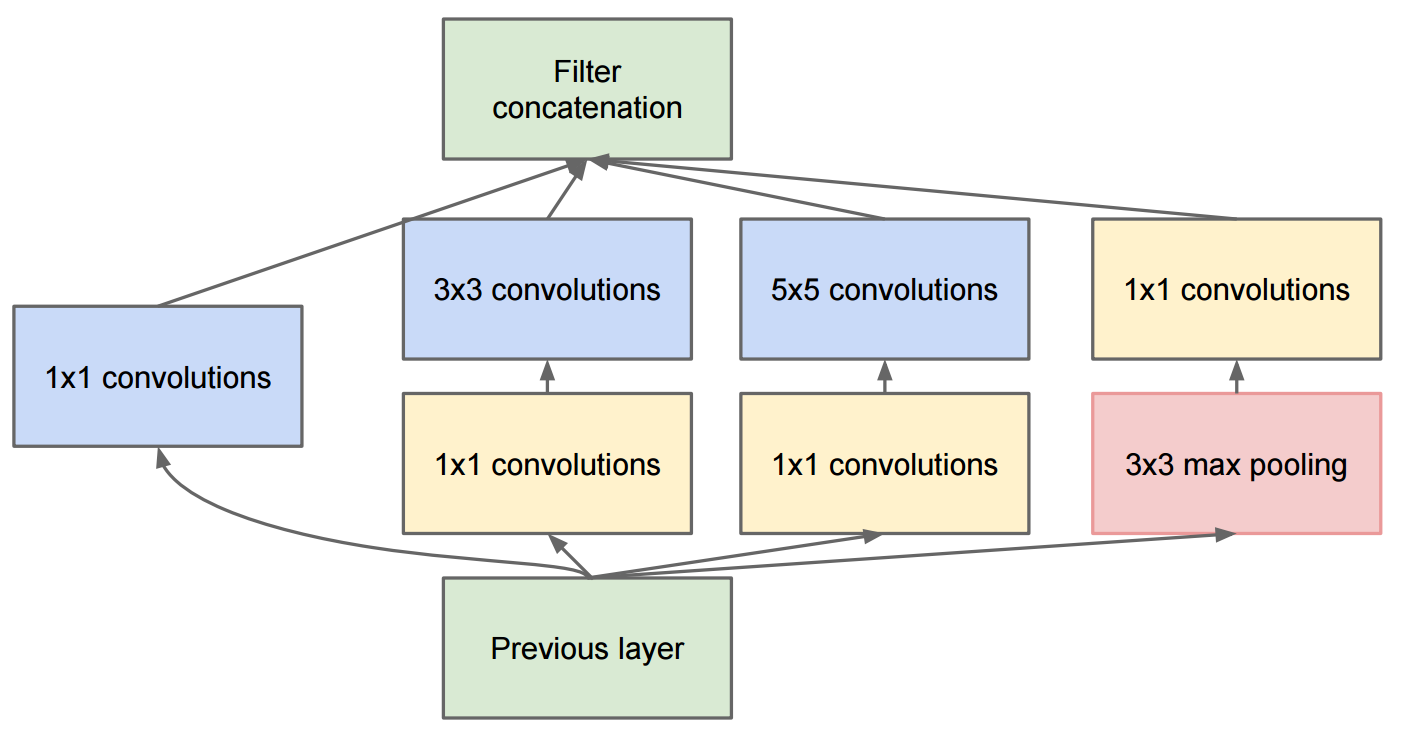

In [22]:
from IPython import display
display.Image("https://i.stack.imgur.com/zTinD.png")

In [35]:
class InceptionBlock_V1(keras.layers.Layer):

    def __init__(self,num_filter1,num_filter21,num_filter22,num_filter31,num_filter32,num_filter4):

        super(InceptionBlock_V1, self).__init__()
        
        self.branch1=ConvBlock(num_filters=num_filter1,kernel_size=(1,1),strides=(1,1),padding='same',activation="relu")
        
        self.branch2=Sequential([
            ConvBlock(num_filters=num_filter21,kernel_size=(1,1),strides=(1,1),padding='same',activation="relu"),
            ConvBlock(num_filters=num_filter22,kernel_size=(3,3),strides=(1,1),padding='same',activation="relu")
        ])
        
        self.branch3=Sequential([
            ConvBlock(num_filters=num_filter31,kernel_size=(1,1),strides=(1,1),padding='same',activation="relu"),
            ConvBlock(num_filters=num_filter32,kernel_size=(5,5),strides=(1,1),padding='same',activation="relu")
        ])
        
        self.branch4=Sequential([
            MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same'),
            ConvBlock(num_filters=num_filter4,kernel_size=(1,1),strides=(1,1),padding='same',activation="relu")
        ])

    def call(self, inputs):
        branches=(self.branch1,self.branch2,self.branch3,self.branch4)
        return tf.concat([branch(inputs) for branch in branches],axis=3)
    

### Conception de Mini Inception_V1
Notre objectif est construire un modèle simple qui utilise les **Block d'Inception_V1**

#### Définition et implémentation du modèle

In [36]:
class MiniInception_V1(keras.Model):

    def __init__(self,units=1024,dropout=0.4):

        super(MiniInception_V1,self).__init__()

        self.layer1=Sequential([
            ConvBlock(num_filters=64,kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])
        
        self.layer2=Sequential([
            InceptionBlock_V1(num_filter1=64,num_filter21=48,num_filter22=64,num_filter31=32,num_filter32=64,num_filter4=64),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])

        self.layer3=Sequential([
            InceptionBlock_V1(num_filter1=128,num_filter21=96,num_filter22=128,num_filter31=64,num_filter32=128,num_filter4=128),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])

        self.layer4=Sequential([
            InceptionBlock_V1(num_filter1=256,num_filter21=192,num_filter22=256,num_filter31=128,num_filter32=256,num_filter4=256),
            MaxPooling2D(pool_size=(2,2),strides=(2,2))
        ])
        
        self.gap=GlobalAveragePooling2D(name="GlobalAveragePooling2D")
        self.flatten=Flatten()
        
        self.mlp=MLPs(units=units,dropout=dropout)

    def call(self,inputs):
        layer=self.layer1(inputs)
        layer=self.layer2(layer)
        layer=self.layer3(layer)
        layer=self.layer4(layer)
        flatten=self.flatten(self.gap(layer))

        return self.mlp(flatten)

#### Instanciation du modèle
La même procedure d'entraînement que celle de **Mini VGG** est appliquée ici

In [108]:
data=Input(shape=(28,28,1))
miniInception_V1=MiniInception_V1(dropout=0.6)
conv=miniInception_V1(data)

checkpoint_filepath = 'best_mini_Inception_V1.h5'
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)
model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

miniInception_V1=keras.Model(inputs=data,outputs=conv)
miniInception_V1.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 mini_inception_v1_1 (MiniI  (None, 5)                 3268981   
 nception_V1)                                                    
                                                                 
Total params: 3268981 (12.47 MB)
Trainable params: 3264149 (12.45 MB)
Non-trainable params: 4832 (18.88 KB)
_________________________________________________________________


In [109]:
opt=keras.optimizers.RMSprop(learning_rate=0.0001,momentum=0.9)
miniInception_V1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = miniInception_V1.fit(train_data, epochs=100, validation_data=valid_data,callbacks=[model_checkpoint])

Epoch 1/100
2344/2344 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9280
Epoch 1: val_accuracy improved from -inf to 0.92836, saving model to best_mini_Inception_V1.h5
2344/2344 [==============================] - 538s 228ms/step - loss: 0.2201 - accuracy: 0.9280 - val_loss: 0.2245 - val_accuracy: 0.9284
Epoch 2/100
2344/2344 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9583
Epoch 2: val_accuracy improved from 0.92836 to 0.93248, saving model to best_mini_Inception_V1.h5
2344/2344 [==============================] - 534s 228ms/step - loss: 0.1240 - accuracy: 0.9583 - val_loss: 0.2104 - val_accuracy: 0.9325
Epoch 3/100
2344/2344 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9651
Epoch 3: val_accuracy improved from 0.93248 to 0.95900, saving model to best_mini_Inception_V1.h5
2344/2344 [==============================] - 534s 228ms/step - loss: 0.1026 - accuracy: 0.9651 - val_loss: 0.1237 - val_accuracy: 0.9590
E

* **96.78%** d'accuracy sur sur le jeux de données de validation avec un entraînement sur le jeu de données d'entrainement obtenu par **data augmentation**
* L'accuracy s'est nettement amélioré comparé à **Mini VGG** ayant un accuracy de **96.64%** mais en baisse comparé à **Mini resnet** ayant un accuracy de **96.82%** 

## Conclusion
* Le meilleur modèle d'entre les trois architectures et celui utilisant les skipping connection (Mini Resnet) avec une précision de **96.82%**.
* La data augmentation a permis de gagner près de **2%** d'accuracy sur le jeu de données de validation.
* Decouverte
## Perspective d'amélioration
* Data augmentation utilisant les **GANs** et la technique du**cutout** en plus de celle mise en place ici
* Utiliser d'autres architecture de l'état de l'art comme les **Vision Transformer**
* Utiliser du transfer learning

## Conclusion Personnelle
* Comprehension plus approfondie des différences couches de réseaux de neurones.
* Découverte et comprehension de architectures des modèles de l'état de l'art (**GoogleNet, Resnet, VGG**).
* Mise en place des modèle de réseaux de neurones profond en partant de zéro
J'ai fait de choix de mettre en place mes propres modèles afin de me familialiser et de plus apprendre quand à la mise place de réseaux de neurones profond. J'ai également tester le **Transfer Learning** afin de m'assurer qu'il ne surpasse pas mes modèles, cependant l'entraônement était très lent au vu de la taille de ces dernier. Je n'ai constater de résultat surpassant le mien au bout de quelques itérations alors j'ai décider de me focaliser sur la conceptioon de propre modèle moins lourds mais  aussi performant, ce qui pourrait me garantir **un temps d'inférence plus intéressant**